Evaluate the WIS performance of two different models:

The *Interval score* was computed using the formula below: 

$$
S^{int}_\alpha(l_i, u_i; y_i) = u_i - l_i + \cfrac{2}{\alpha}(l_i - y_i)I\{y_i < l_i\} + \cfrac{2}{\alpha}(y_i - u_i)I\{y_i > u_i\}
$$

where $I$ is the indicator function, $\alpha$ the significance level of the interval, $u_i$ the upper value of the interval at week $i$ and $l_i$ the lower value. 

The weighted interval score (WIS) is compute using the equation below:
$$
\text{WIS}(F, y) = \frac{1}{K + 1/2} \left( w_0|y - m| + \sum_{k=1}^K [w_K S^{int}_{\alpha_k} (l_K, u_K; y) ]\right), 
$$

by default, $ w_k = \frac{\alpha_k}{2}$ and  $w_0 = \frac{1}{2}$. In this equation, $K$ denotes the number of intervals, and $l_k$ and $u_k$ represent the lower and upper bounds of the $k$-th confidence interval, respectively. The implementation defines the $\alpha_k$ values based on the names of the prediction columns.


Para os intervalos do sprint, 50, 80, 90 e 95, os pesos serão: $w_k =  [0.25, 0.1, 0.05, 0.025]$

In [1]:
import numpy as np
import pandas as pd
import mosqlient as mosq
from epiweeks import Week
from itertools import product 
import matplotlib.pyplot as plt
from mosqlient.scoring import compute_wis

Load the data: 

In [2]:
data = pd.read_csv('data/dengue_agg.csv.gz')
data.date = pd.to_datetime(data.date)
data = data.sort_values(by = 'date')
data.head()

,date,uf,casos
0,2010-01-03,AC,760
26,2010-01-03,ES,164
25,2010-01-03,MS,1859
24,2010-01-03,MG,2124
23,2010-01-03,MA,13


Get the range of the peaks in a three week window centered in the peak: 

In [3]:
data_23 = data.loc[(data.date >= Week(2022, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2023, 40).startdate().strftime('%Y-%m-%d'))] 
data_24 = data.loc[(data.date >= Week(2023, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2024, 40).startdate().strftime('%Y-%m-%d'))] 
data_25 = data.loc[(data.date >= Week(2024, 41).startdate().strftime('%Y-%m-%d')) & (data.date <= Week(2025, 40).startdate().strftime('%Y-%m-%d'))] 

states = data.uf.unique()
years = [2023, 2024, 2025]
peak_dates = {state: {year: {} for year in years} for state in states}

for state in states:
    
    df_23 = data_23.loc[data_23.uf == state]
    
    peak_date = pd.to_datetime(df_23.loc[df_23.casos == df_23['casos'].max()].date.values[0])

    peak_dates[state][2023]['peak_date'] = peak_date

    df_24 = data_24.loc[data_24.uf == state]
    
    peak_date = pd.to_datetime(df_24.loc[df_24.casos == df_24['casos'].max()].date.values[0])

    peak_dates[state][2024]['peak_date'] = peak_date

    df_25 = data_25.loc[data_25.uf == state]
    
    peak_date = pd.to_datetime(df_25.loc[df_25.casos == df_25['casos'].max()].date.values[0])

    peak_dates[state][2025]['peak_date'] = peak_date

Load the predictions: 

In [4]:
df_preds = pd.read_csv('data/preds_2nd_sprint.csv.gz')

df_preds['date'] = pd.to_datetime(df_preds.date)

# Delete the model with invalid predictions
df_preds  = df_preds.loc[df_preds.model_id != 141]

df_preds['valid_test'] = df_preds['valid_test'].astype(str)
df_preds.head()

/var/folders/ch/kxpr39wx44v97968yr_4hmch0000gn/T/ipykernel_30563/188675296.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_preds = pd.read_csv('data/preds_2nd_sprint.csv.gz')


,date,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95,valid_test,state,model_id
0,2024-10-06,22.422222,40.304679,79.162970,244.274988,853.700012,2982.915845,9196.810733,18041.732884,32366.797486,3,RS,108
1,2024-10-13,18.743651,34.187301,68.269130,216.515891,779.997873,2809.263104,8900.886361,17748.532118,32294.740637,3,RS,108
2,2024-10-20,6.581569,12.226861,24.874887,81.165077,301.351891,1118.132411,3638.484729,7371.869282,13600.483733,3,RS,108
3,2024-10-27,17.097895,32.060474,66.082749,220.934380,843.905436,3222.679992,10763.205908,22149.610067,41420.387215,3,RS,108
4,2024-11-03,18.724941,35.572182,74.438413,255.270334,1003.039414,3940.407380,13500.169745,28209.239339,53454.977878,3,RS,108


In [5]:
def compute_metrics(model, df_w, df_preds_, state=None, year=None, peak = False, w_k = None):
    '''
    Function to compute the score for the entire validation test or only around the peak (if peak=True).
    '''

    if peak: 

        pw = peak_dates[state][2022+int(year)]['peak_date']

        start = Week.fromdate(pw - pd.Timedelta(days = 7)).startdate().strftime('%Y-%m-%d')
    
        end = Week.fromdate(pw + pd.Timedelta(days = 7)).startdate().strftime('%Y-%m-%d')
    
        dates_ =  pd.date_range(start= start,
                  end= end,
                  freq='W-SUN')

        df_preds_2 = df_preds_.loc[df_preds_.date.isin(dates_)]
        
        df_w2 = df_w.loc[df_w.date.isin(dates_)]
    else:
        df_preds_2 = df_preds
        df_w2 = df_w
        
    df_preds_model = df_preds_2.loc[df_preds_2.model_id == model].reset_index(drop = True)
        
    df_preds_to_score = df_w2.merge(df_preds_model, left_on = ['date', 'uf'], right_on = ['date', 'state'])

    wis = np.mean(compute_wis(
                        df_preds_to_score[['date',  'lower_95', 'lower_90', 'lower_80', 'lower_50',
                           'pred', 'upper_50', 'upper_80', 'upper_90', 'upper_95']],
                        observed_value = df_preds_to_score['casos'].values, 
                        w_k = w_k)) 
    return wis

In [6]:
df_metrics = pd.DataFrame()

for state, test_year in product(['PR'], ['2']):
    #print(f'{state} - {test_year}')
    df_preds_ = df_preds.loc[(df_preds.state == state) & (df_preds.valid_test == test_year)]

    df_w = data.loc[(data.uf == state) & data.date.isin(df_preds_.date.unique())].reset_index(drop=True)

    scores =[]
    models_ids = df_preds_.model_id.unique()
    
    for model in models_ids: 
        #print(model)
    
        wis = compute_metrics(model, df_w, df_preds_, state=state, year=test_year, peak = True)
        
        df_metrics = pd.concat([df_metrics,
                           pd.DataFrame([[model, state, test_year, wis ]],
                            columns = ['model', 'state', 'validation_test', 'WIS'] 
                            )], ignore_index = True)

df_metrics.head()

,model,state,validation_test,WIS
0,108,PR,2,36223.418224
1,133,PR,2,42987.449511
2,134,PR,2,27359.975069
3,135,PR,2,20268.508287
4,136,PR,2,32020.654861


In [7]:
df_metrics_wk = pd.DataFrame()

for state, test_year in product(['PR'], ['2']):
    #print(f'{state} - {test_year}')
    df_preds_ = df_preds.loc[(df_preds.state == state) & (df_preds.valid_test == test_year)]

    df_w = data.loc[(data.uf == state) & data.date.isin(df_preds_.date.unique())].reset_index(drop=True)

    scores =[]
    models_ids = df_preds_.model_id.unique()
    
    for model in models_ids: 
        #print(model)
    
        wis = compute_metrics(model, df_w, df_preds_, state=state, year=test_year, peak = True, w_k = [1, 1, 1, 1])
        
        df_metrics_wk = pd.concat([df_metrics_wk,
                           pd.DataFrame([[model, state, test_year, wis ]],
                            columns = ['model', 'state', 'validation_test', 'WIS'] 
                            )], ignore_index = True)

df_metrics_wk.head()

,model,state,validation_test,WIS
0,108,PR,2,717414.430457
1,133,PR,2,701800.251406
2,134,PR,2,423385.221638
3,135,PR,2,247138.183333
4,136,PR,2,460250.931075


In [8]:
df_metrics.sort_values(by = 'WIS').head(5)

,model,state,validation_test,WIS
6,138,PR,2,16925.225709
16,157,PR,2,19817.600000
3,135,PR,2,20268.508287
5,137,PR,2,23532.729371
13,154,PR,2,23572.306796


In [9]:
df_metrics_wk.sort_values(by = 'WIS').head(5)

,model,state,validation_test,WIS
16,157,PR,2,148792.000000
13,154,PR,2,174353.869024
9,144,PR,2,205019.838889
3,135,PR,2,247138.183333
5,137,PR,2,262164.643369


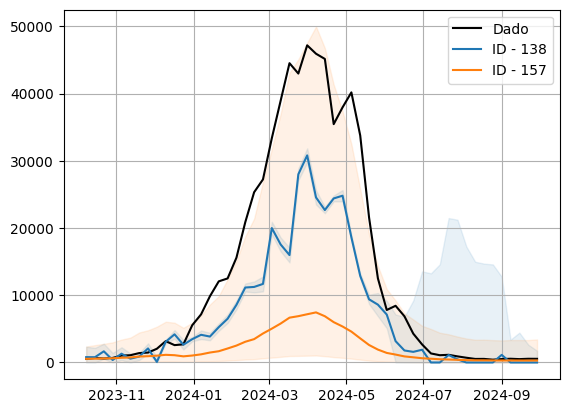

In [11]:
dft = df_preds.loc[(df_preds.model_id == 138) & (df_preds.state =='PR') & (df_preds.valid_test =='2')]

dft2 = df_preds.loc[(df_preds.model_id == 157) & (df_preds.state =='PR') & (df_preds.valid_test =='2')]

_, ax = plt.subplots()

data_ = data_24.loc[(data_24.uf == 'PR')]

ax.plot(data_.date, data_.casos, color = 'black', label = 'Dado')

ax.plot(dft.date, dft.pred, label = 'ID - 138')

ax.fill_between(dft.date, dft.lower_95, dft.upper_95, color = 'tab:blue', alpha = 0.1)

ax.plot(dft2.date, dft2.pred, color = 'tab:orange', label = 'ID - 157')

ax.fill_between(dft2.date, dft2.lower_95, dft2.upper_95, color = 'tab:orange', alpha = 0.1)

ax.grid()
ax.legend()

plt.show()

Comparing the mosqlient with the Davi WIS implementation: 

In [18]:

def compute_wis2(quantiles, y, taus):
    """
    - quantiles (list): List of predictive quantiles q_1 to q_K
    - y (float): Observed quantity
    - taus (list): List of corresponding tau values (e.g., [0.025, 0.25, 0.5, 0.75, 0.975])
    
    Returns:
        float: WIS value
    """
    K = len(quantiles)
    wis = 0
    for k in range(K):
        indicator = 1 if y <= quantiles[k] else 0
        wis += 2 * (indicator - taus[k]) * (quantiles[k] - y)
    return wis / K
    
def maybe_compute_wis(quantiles, y, taus):
    try:
        return compute_wis(quantiles, y, taus)
    except Exception:
        return np.nan

        
taus = [0.025,0.05, 0.1,0.25,0.5,0.75,0.9,0.95, 0.975]

In [19]:
df_preds.loc[1:1, : ][['date',  'lower_95', 'lower_90', 'lower_80', 'lower_50',
                           'pred', 'upper_50', 'upper_80', 'upper_90', 'upper_95']]

,date,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95
1,2024-10-13,18.743651,34.187301,68.26913,216.515891,779.997873,2809.263104,8900.886361,17748.532118,32294.740637


In [20]:
compute_wis2([18.7436505312, 34.187300951, 68.2691296911, 216.5158906235,
       779.997872651, 2809.2631042624, 8900.8863613085, 17748.5321184939,
       32294.7406365436], 100, taus)

817.9067820106491

In [21]:
compute_wis(df_preds.loc[1:1, : ][['date',  'lower_95', 'lower_90', 'lower_80', 'lower_50',
                           'pred', 'upper_50', 'upper_80', 'upper_90', 'upper_95']],
                        observed_value = [100]) 

array([817.90678201])

Both return the same score value. 